In [1]:
import networkx as nx

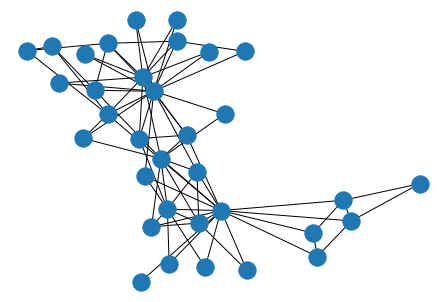

In [2]:
# Create a graph and visualize it
G = nx.karate_club_graph()

import matplotlib.pyplot as plt
nx.draw(G)

In [3]:
import gurobipy as gp
from gurobipy import GRB

In [4]:
# Enumerate *all* maximal independent sets, i.e., 
#   all independent sets that are dominating 

# Create model object
m = gp.Model()

# Create variable for each node
x = m.addVars( G.nodes, vtype=GRB.BINARY )

# No objective
m.setObjective( 0.0, GRB.MINIMIZE )

# Constraints: should be independent
m.addConstrs( x[i] + x[j] <= 1 for i,j in G.edges )

# Constraints: should be dominating
m.addConstrs( x[i] + gp.quicksum( x[j] for j in G.neighbors(i) ) >= 1 for i in G.nodes )

# Find the N best solutions
N = 100000
m.Params.PoolSearchMode = 2 # finds N best solutions
m.Params.PoolSolutions = N

# Solve
m.optimize()

Academic license - for non-commercial use only - expires 2021-07-26
Using license file C:\Users\Austin\gurobi.lic
Changed value of parameter PoolSearchMode to 2
   Prev: 0  Min: 0  Max: 2  Default: 0
Changed value of parameter PoolSolutions to 100000
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 112 rows, 34 columns and 346 nonzeros
Model fingerprint: 0xdba33f57
Variable types: 0 continuous, 34 integer (34 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 81 rows and 11 columns
Presolve time: 0.10s
Presolved: 31 rows, 23 columns, 96 nonzeros
Variable types: 0 continuous, 23 integer (23 binary)

Root relaxation: objective 0.000000e+00, 10 iterations, 0.01

[0, 9, 16, 25, 26, 27, 28, 32]


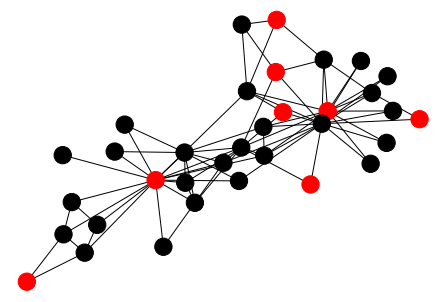

In [5]:
# draw the first maximal ind set
m.Params.SolutionNumber = 0
ind_set = [ i for i in G.nodes if x[i].Xn > 0.5 ] 
print(ind_set)

node_colors = [ "red" if i in ind_set else "black" for i in G.nodes ]

nx.draw( G, node_color=node_colors )

In [6]:
# retrieve maximal ind sets
ind_sets = list()

for sol in range(m.SolCount):
    m.Params.SolutionNumber = sol
    ind_set = [ i for i in G.nodes if x[i].Xn > 0.5 ]
    ind_sets.append(ind_set)
    
print("Number of maximal ind sets =",len(ind_sets)) 

Number of maximal ind sets = 228


In [7]:
# Create (new) model object for set covering instance
m = gp.Model()

# Create variable for each ind set
x = m.addVars( len(ind_sets), vtype=GRB.BINARY )

# Objective function: minimize the number of ind sets used
m.setObjective( gp.quicksum( x[j] for j in range(len(ind_sets)) ), GRB.MINIMIZE )

# Constraints: each node should be covered at least once
m.addConstrs( gp.quicksum( x[j] for j in range(len(ind_sets)) if i in ind_sets[j] ) >= 1 for i in G.nodes )

# Solve
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 34 rows, 228 columns and 3526 nonzeros
Model fingerprint: 0x9587cf38
Variable types: 0 continuous, 228 integer (228 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 17 rows and 137 columns
Presolve time: 0.05s
Presolved: 17 rows, 91 columns, 448 nonzeros
Variable types: 0 continuous, 91 integer (91 binary)

Root relaxation: objective 5.000000e+00, 12 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       5.0000000    5.00000  0.00%     -    0s

Explored 0 nodes (12 simplex iterations) in 0.13 seconds
Th

In [8]:
# Retrieve the selected ind sets
selected_ind_sets = [ ind_sets[j] for j in range(len(ind_sets)) if x[j].x > 0.5 ]
print(selected_ind_sets)

[[0, 9, 14, 15, 16, 18, 20, 22, 24, 28, 29, 30], [1, 4, 5, 8, 9, 11, 12, 14, 15, 18, 20, 22, 23, 26, 31], [3, 4, 5, 8, 9, 11, 14, 15, 17, 18, 19, 20, 21, 22, 25, 27, 28, 29], [2, 4, 5, 11, 12, 17, 21, 24, 33], [6, 7, 9, 10, 11, 12, 13, 17, 19, 21, 24, 26, 28, 32]]


In [9]:
# Turn this into a coloring
coloring = [ -1 for i in G.nodes ]

for j in range(len(selected_ind_sets)):
    for i in selected_ind_sets[j]:
        coloring[i] = j
        
print(coloring)

[0, 1, 3, 2, 3, 3, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 0, 4, 2, 4, 2, 4, 2, 1, 4, 2, 4, 2, 4, 2, 0, 1, 4, 3]


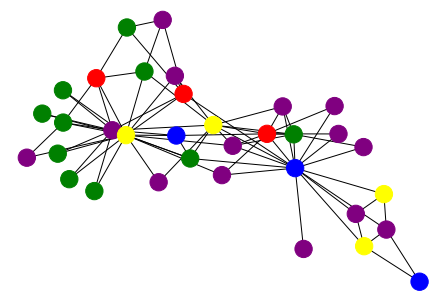

In [10]:
# Draw it
palette = ["blue", "red", "green", "yellow", "purple"]

node_colors = [ palette[coloring[i]] for i in G.nodes ]

nx.draw( G, node_color=node_colors )